https://github.com/SamuReyes/LunarLanderRL/tree/3a7d1dd3e887192197cf133c2ef1fc55e503fede

https://github.com/anh-nn01/Lunar-Lander-Double-Deep-Q-Networks/tree/master

Prueba a controlar el flappy bird https://github.com/markub3327/flappy-bird-gymnasium

pip install flappy-bird-gymnasium

import flappy_bird_gymnasium  
env = gym.make("FlappyBird-v0")

Estado (12 variables):
  * the last pipe's horizontal position
  * the last top pipe's vertical position
  * the last bottom pipe's vertical position
  * the next pipe's horizontal position
  * the next top pipe's vertical position
  * he next bottom pipe's vertical position
  * the next next pipe's horizontal position
  * the next next top pipe's vertical position
  * the next next bottom pipe's vertical position
  * player's vertical position
  * player's vertical velocity
  * player's rotation

  Acciones:
  * 0 -> no hacer nada
  * 1 -> volar

In [6]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import gymnasium.utils.play
import pygame
import time
from gymnasium.wrappers import RecordVideo
import flappy_bird_gymnasium  

from MLP import MLP
from AGFlappyBird import AG_Flappy_Bird

%matplotlib inline

## **Human play**

In [ ]:
env = gym.make("FlappyBird-v0", render_mode="rgb_array")
gymnasium.utils.play.play(env, zoom=1.5, keys_to_action={(pygame.K_UP,): 1}, noop=0)

----

## **Agent training**

In [21]:
env = gym.make("FlappyBird-v0", use_lidar=False)
architecture = MLP(layers=[12,8,4,2])
genetic_algorithm = AG_Flappy_Bird(population_size=100, num_ind_exp=5, MLP=architecture, env=env, env_seed=None)

print("model params:", genetic_algorithm.MLP.size)

start = time.time()
GENERATIONS = 5000
trace = 250
genetic_algorithm.evolve(pmut=0.1, pcross=0.7, ngen=GENERATIONS, T=8, trace=trace, reverse_sort=True, elitism=False)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

best_chromosome = genetic_algorithm.best_global_individual[1]
np.savetxt(f"results_p1/flappy_bird_AG_{GENERATIONS}_best.txt", best_chromosome)
# save last best individual
np.savetxt(f"results_p1/flappy_bird_AG_{GENERATIONS}_last.txt", genetic_algorithm.population[0])

model params: 150
Nº gen: 0, Best fitness: 4.5799999999999965
Nº gen: 250, Best fitness: 9.079999999999995
Nº gen: 500, Best fitness: 7.979999999999997
Nº gen: 750, Best fitness: 11.559999999999999
Nº gen: 1000, Best fitness: 10.75999999999998
Nº gen: 1250, Best fitness: 8.159999999999988
Nº gen: 1500, Best fitness: 10.85999999999999
Nº gen: 1750, Best fitness: 9.459999999999996
Nº gen: 2000, Best fitness: 11.179999999999989
Nº gen: 2250, Best fitness: 9.839999999999996
Nº gen: 2500, Best fitness: 10.600000000000005
Nº gen: 2750, Best fitness: 13.48000000000001
Nº gen: 3000, Best fitness: 12.380000000000022
Nº gen: 3250, Best fitness: 11.45999999999998
Nº gen: 3500, Best fitness: 11.020000000000014
Nº gen: 3750, Best fitness: 11.780000000000012
Nº gen: 4000, Best fitness: 11.700000000000001
Nº gen: 4250, Best fitness: 12.140000000000015
Nº gen: 4500, Best fitness: 11.859999999999996
Nº gen: 4750, Best fitness: 11.439999999999992
Nº gen: 4999, Best fitness: 13.100000000000012
*******Tie

## **Fitnesses evolution**

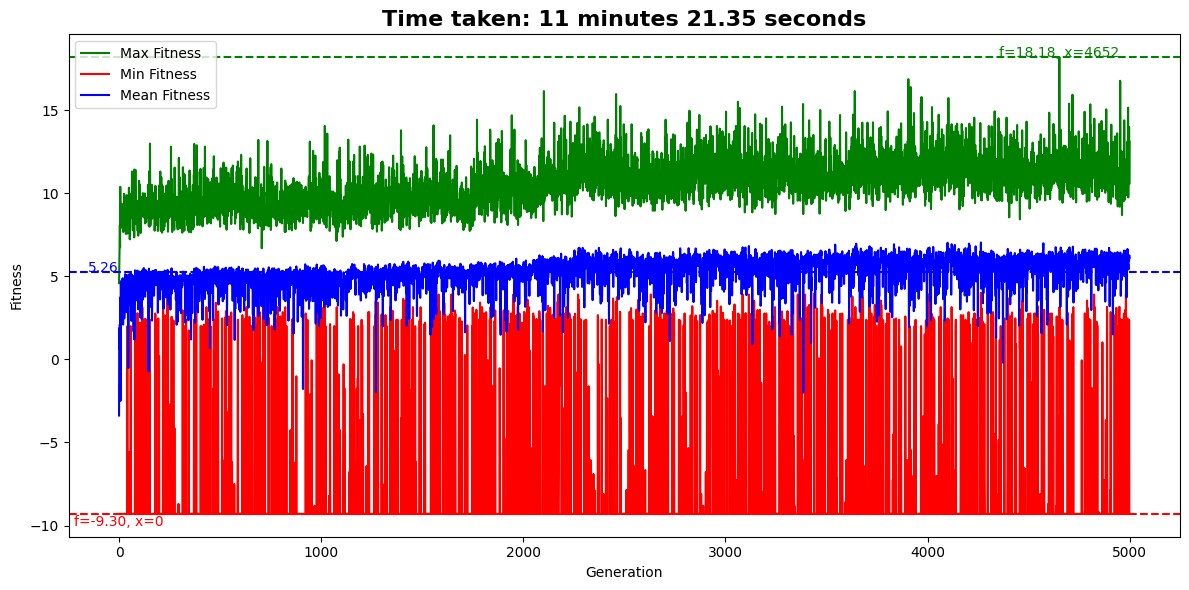

In [22]:
def plot_fitnesses_evolution():
    plt.figure(figsize=(12, 6))
    
    max_fitness = genetic_algorithm.max_fitnesses
    min_fitness = genetic_algorithm.min_fitnesses
    mean_fitness = genetic_algorithm.mean_fitnesses
    
    max_episode = np.argmax(max_fitness)
    min_episode = np.argmin(min_fitness)

    # Get current y-axis limits and compute an offset (2% of y-range)
    ax = plt.gca()
    ymin_axis, ymax_axis = ax.get_ylim()
    offset = (ymax_axis - ymin_axis) * 0.02

    # Adjust offsets; change sign as needed (positive: above, negative: below)
    min_offset = -offset-0.7  # places min text below the line
    max_offset = offset   # places max text above the line
    
    plt.plot(max_fitness, label="Max Fitness", color='g')
    plt.axhline(y=max(max_fitness), color='g', linestyle='--')
    plt.text(max_episode, max(max_fitness) + max_offset, f"f={max(max_fitness):.2f}, x={max_episode}", color='g', ha="center")
    
    plt.plot(min_fitness, label="Min Fitness", color='r')
    plt.axhline(y=min(min_fitness), color='r', linestyle='--')
    plt.text(min_episode, min(min_fitness) + min_offset, f"f={min(min_fitness):.2f}, x={min_episode}", color='r', ha="center")
        
    plt.plot(mean_fitness, label="Mean Fitness", color='b')
    plt.axhline(y=np.mean(mean_fitness), color='b', linestyle='--')
    plt.text(0, np.mean(mean_fitness) + max_offset, f'{np.mean(mean_fitness):.2f}', color='b', ha='right') # mean value

    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(f"Time taken: {int(minutos)} minutes {segundos:.2f} seconds", fontsize=16, ha='center', fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"results_p1/flappy_bird_AG_{GENERATIONS}.png")
    plt.show()

plot_fitnesses_evolution()

## **Test best global chromosome**

In [11]:
test_chromosome = np.loadtxt(f"results_p1/flappy_bird_AG_{GENERATIONS}_best.txt").tolist()
test_model = architecture # previously defined MLP architecture
test_model.from_chromosome(test_chromosome)

num_episodes_test = 10
destiny_folder = "results_p1/videos"
test_env = gym.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=False)
test_env = RecordVideo(test_env, video_folder=destiny_folder, name_prefix=f"FB-AG-{GENERATIONS}", episode_trigger=lambda x: x < num_episodes_test)  

def policy(observation):
    s = test_model.forward(observation)
    action = np.argmax(s)
    return action

for episode in range(num_episodes_test):
    state, _ = test_env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = policy(state)  
        next_state, reward, done, _, _ = test_env.step(action) 
        total_reward += reward
        state = next_state

        if done:
            print(f"Episode {episode}: Episode Reward = {total_reward}")

test_env.close()

Episode 0: Episode Reward = 12.899999999999974
Episode 1: Episode Reward = 18.00000000000001
Episode 2: Episode Reward = 13.299999999999972
Episode 3: Episode Reward = 22.50000000000006
Episode 4: Episode Reward = 18.400000000000016
Episode 5: Episode Reward = 13.79999999999997
Episode 6: Episode Reward = 8.499999999999986
Episode 7: Episode Reward = 8.399999999999986
Episode 8: Episode Reward = 13.299999999999972
Episode 9: Episode Reward = 17.90000000000001


## **Custom Video Recorder Class**

In [47]:
import threading
import queue
import imageio
import gymnasium as gym

class AsyncVideoRecorder:
    def __init__(self, filename, fps=30):
        """
        Inicializa el grabador asíncrono.
        :param filename: Nombre del archivo de salida (por ejemplo, "entire_game.mp4")
        :param fps: Frames por segundo del video.
        """
        self.filename = filename
        self.fps = fps
        self.frame_queue = queue.Queue()
        self.stop_event = threading.Event()
        self.writer = None
        self.thread = threading.Thread(target=self._writer)
        self.thread.start()

    def _writer(self):
        """
        Función que corre en un hilo separado y se encarga de escribir los frames en el archivo.
        """
        while not self.stop_event.is_set() or not self.frame_queue.empty():
            try:
                # Espera un frame (timeout para permitir comprobar el stop_event)
                frame = self.frame_queue.get(timeout=0.1)
                if self.writer is None:
                    # Inicializa el writer cuando llega el primer frame
                    # Se asume que el frame es un array numpy (alto, ancho, canales)
                    self.writer = imageio.get_writer(self.filename, fps=self.fps)
                self.writer.append_data(frame)
                self.frame_queue.task_done()
            except queue.Empty:
                continue
        if self.writer is not None:
            self.writer.close()

    def write(self, frame):
        """
        Envía un frame a la cola para ser escrito.
        :param frame: Un frame (por ejemplo, obtenido de env.render())
        """
        self.frame_queue.put(frame)

    def close(self):
        """
        Finaliza el grabador, esperando a que se vacíe la cola y se cierre el writer.
        """
        self.stop_event.set()
        self.thread.join()

# ------------------------------------------------
env = gym.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=False)
video_recorder = AsyncVideoRecorder("entire_game.mp4", fps=30)

def policy(observation):
    s = test_model.forward(observation)
    action = np.argmax(s)
    return action

state, _ = env.reset()
done = False
episode_reward = 0

while not done:
    # Aquí implementas la política o la acción a ejecutar:
    action = policy(state)  # tu función para decidir la acción
    next_state, reward, done, _, _ = env.step(action)
    episode_reward += reward
    
    # Captura el frame actual
    frame = env.render()  # Se espera un frame en formato RGB
    video_recorder.write(frame)
    
    state = next_state

env.close()
video_recorder.close()
print(f"Episode Reward = {episode_reward}")

Episode Reward = 17.90000000000001
